In [2]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)


# import cv2
import numpy as np
import os
import csv

# Open the webcam
video = cv2.VideoCapture(0)
facedetect = cv2.CascadeClassifier(r"C:\Users\MY\DSP1\db\haarcascade_frontalface_default.xml")

faces_data = []
i = 0

name = input("Enter your name: ")

# Check if the camera is opened successfully
if not video.isOpened():
    print("Error: Unable to access the camera")
    exit()

# Directory path for saving the data
directory = os.path.join(os.path.expanduser("~"), "DSP1", "db")
if not os.path.exists(directory):
    os.makedirs(directory)

while True:
    ret, frame = video.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facedetect.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        crop_image = frame[y:y + h, x:x + w, :]
        resized_img = cv2.resize(crop_image, (50, 50))

        if len(faces_data) <= 100 and i % 10 == 0:
            faces_data.append(resized_img)

        i += 1
        cv2.putText(frame, str(len(faces_data)), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (50, 50, 255), 1)

    cv2.imshow("Frame", frame)

    k = cv2.waitKey(1)
    if k == ord('o') or len(faces_data) == 100:
        break

# Release the webcam and close the window
video.release()
cv2.destroyAllWindows()

# Process and save the captured data
faces_data = np.asarray(faces_data)
faces_data = faces_data.reshape(faces_data.shape[0], -1)  # Flatten the faces to 1D array for CSV

# Prepare the name list (100 occurrences of the entered name)
names = [name] * len(faces_data)

# Save faces and names as CSV
faces_csv_path = os.path.join(directory, 'faces.csv')
names_csv_path = os.path.join(directory, 'names.csv')

# Save faces (flattened) and corresponding names into CSV
with open(faces_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(faces_data)):
        writer.writerow(list(faces_data[i]))

with open(names_csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    for name in names:
        writer.writerow([name])  # Write each name on a new row

print(f"Faces data saved to {faces_csv_path} and names data saved to {names_csv_path}")

In [6]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.0-cp39-cp39-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.0-cp39-cp39-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [7]:
!pip install pandas

  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [8]:
from sklearn.neighbors import KNeighborsClassifier
import cv2
import numpy as np
import os
import csv
import pandas as pd
import time
from datetime import datetime
from win32com.client import Dispatch

def speak(str1):
    speak = Dispatch(("SAPI.SpVoice"))
    speak.Speak(str1)

# Open the webcam
video = cv2.VideoCapture(0)
facedetect = cv2.CascadeClassifier(r"C:\Users\MY\DSP1\db\haarcascade_frontalface_default.xml")

# Load faces and names from CSV
faces = pd.read_csv(r"C:\users\my\DSP1\db\faces.csv", header=None).values  # faces CSV should be rows of flattened images
names = pd.read_csv(r"C:\users\my\DSP1\db\names.csv", header=None).values.flatten()  # names CSV should be a single column of names

print(f"Faces length: {len(faces)}")
print(f"Names length: {len(names)}")

# Check if faces and names have the same length
if len(faces) == len(names):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(faces, names)  # Train KNN model
else:
    print("Error: The number of faces and names do not match.")

imgBackground = cv2.imread(r"C:\Users\MY\yolov8\roboflow screenshot\background.png")

COL_NAMES = ['NAME:','TIME']
while True:
    ret, frame = video.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = facedetect.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in detected_faces:
        crop_image = frame[y:y + h, x:x + w, :]
        resized_img = cv2.resize(crop_image, (50, 50)).flatten().reshape(1, -1)  # Flatten image to match the trained data
        output = knn.predict(resized_img)  # Predict the name based on the face
        ts = time.time()
        date = datetime.fromtimestamp(ts).strftime("%d-%m-%Y")
        timestamp = datetime.fromtimestamp(ts).strftime("%H : %M : %S")
        exist = os.path.isfile("Attendance/Attendance_"+date+".csv")
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),1)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (50, 50,255),2)
        cv2.rectangle(frame, (x,y-40), (x+w,y), (50, 50, 255), -1)
        cv2.putText(frame, str(output[0]), (x, y - 15), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 1)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (50, 50, 255), 1)
        attendance=[str(output[0]),str(timestamp)]

    imgBackground[162:162+480,55:55+640]=frame

    cv2.imshow("Frame", imgBackground)

    k = cv2.waitKey(1)
    if k==ord('o'):
        speak("Attendance Taken, Have a nice day!!")
        time.sleep(3)
        if exist:
            with open("Attendance/Attendance_" + date + ".csv", "+a") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(attendance)
            csvfile.close()
        else:
            with open("Attendance/Attendance_"+date+".csv","+a") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(COL_NAMES)
                writer.writerow(attendance)
            csvfile.close()
    if k == ord('o'):
        break

# Release the webcam and close the window
video.release()
cv2.destroyAllWindows()

Faces length: 100
Names length: 100


In [4]:
!pip install matplotlib

  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp39-cp39-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 1.3 MB/s eta 0:00:06
   ---- ----------------------------------- 0.8/7.8 MB 1.2 MB/s eta 0:00:06
   ---- ----------------------------------- 0.8/7.8 MB 1.2 MB/s eta 0:00:06
   ----- ---------------------------------- 1.0/7.8 MB 1.2 MB/s eta 0:00:06
   -------- ------------------------------- 1.6/7.8 MB 1.2 MB/s e

C:\Users\MY\AppData\Local\Temp\ipykernel_6880\3498033879.py:58: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update_graph, interval=3000)


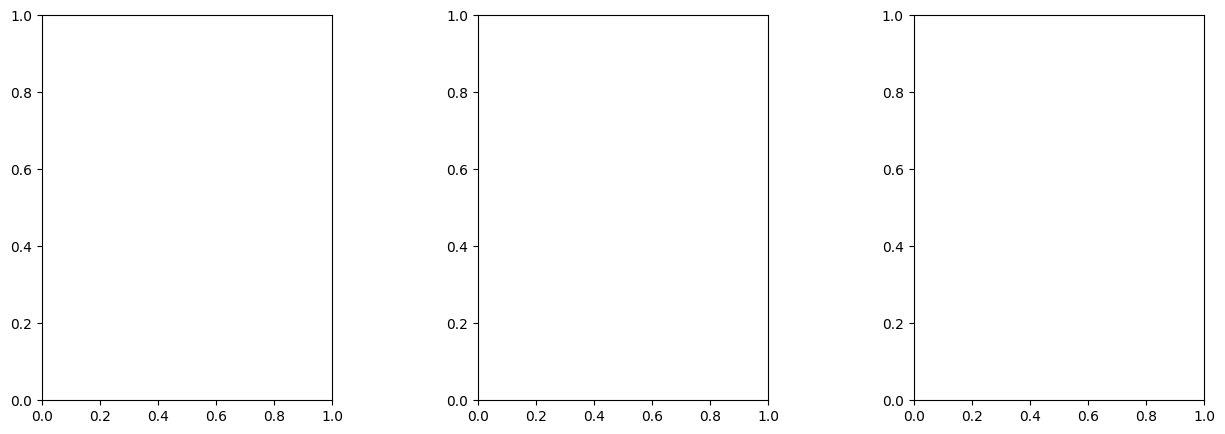

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from datetime import datetime
import os

# Function to get the path of today's attendance CSV file
def get_csv_file():
    date = datetime.now().strftime("%d-%m-%Y")
    return f"Attendance/Attendance_{date}.csv"

# Initialize the figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 grid for the charts
plt.subplots_adjust(wspace=0.5)  # Add space between the charts

# Function to update the graphs dynamically
def update_graph(i):
    csv_file = get_csv_file()  # Get today's CSV file
    if os.path.isfile(csv_file):  # Check if the file exists
        data = pd.read_csv(csv_file)

        # Check if 'NAME:' column exists in the CSV file
        if 'NAME:' in data.columns:
            # Count attendance occurrences by employee names
            counts = data['NAME:'].value_counts()

            # Bar Chart
            axs[0].clear()
            axs[0].bar(counts.index, counts.values, color='skyblue')
            axs[0].set_title("Bar Chart - Attendance Statistics")
            axs[0].set_xlabel("Employee Names")
            axs[0].set_ylabel("Attendance Count")
            axs[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

            # Line Chart
            axs[1].clear()
            axs[1].plot(counts.index, counts.values, marker='o', color='green')
            axs[1].set_title("Line Chart - Attendance Trend")
            axs[1].set_xlabel("Employee Names")
            axs[1].set_ylabel("Attendance Count")
            axs[1].tick_params(axis='x', rotation=45)

            # Donut Chart
            axs[2].clear()
            wedges, texts, autotexts = axs[2].pie(
                counts.values,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                pctdistance=0.85,  # Adjust text position
            )
            axs[2].set_title("Donut Chart - Attendance Proportion")
            # Add a white circle to the center to create the donut effect
            centre_circle = plt.Circle((0, 0), 0.70, fc='white')
            axs[2].add_artist(centre_circle)

# Use Matplotlib's animation to update the charts every 3 seconds
ani = animation.FuncAnimation(fig, update_graph, interval=3000)

# Display the visualization
plt.show()